### Técnicas de Classificação para o dataset total (6 concatenados)

In [2]:
# Confirmar a instalação

import torch
print(torch.__version__)

2.2.2


### Imports

In [3]:
# pytorch mlp for binary classification
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

#from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV


import random
import os
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


set_seed(24)

Random seed set as 24


In [4]:
#####ir buscar o dataset:
#!wget -c https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv -O ionosphere.csv

In [5]:
PATH = './'
PATH_1 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_sinteticos/CSV0_UC_WholeScanMask_clean.csv'
PATH_2 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_sinteticos/CSV0_UC_brainMask_clean.csv'
PATH_3 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_sinteticos/CSV0_UC_tumorMask_clean.csv'
PATH_4 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_reais/CSV1_UC_brainMask_clean.csv'
PATH_5 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_reais/CSV1_UC_tumorMask_clean.csv'
PATH_6 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_reais/CSV1_UC_WholeScanMask_clean.csv'

df_brain_syn = pd.read_csv(PATH_1)
df_brain_real = pd.read_csv(PATH_2)
df_tumor_syn = pd.read_csv(PATH_3)
df_tumor_real = pd.read_csv(PATH_4)
df_whole_syn = pd.read_csv(PATH_5)
df_whole_real = pd.read_csv(PATH_6)

BATCH_SIZE = 32
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### 1. Preparar os Dados

In [6]:
import pandas as pd
import numpy as np
import ast

# Função para preprocessar o dataframe
def preprocess_dataframe(df):
    # Remover coluna "Volume"
    df = df.drop(columns=["Volume"], errors='ignore')

    # Função para converter strings em listas de floats
    def convert_strings_to_floats(col):
        return col.apply(lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) else float(x))

    # Aplicar a conversão a todas as colunas exceto a primeira
    for col in df.columns[1:]:  # Supondo que a primeira coluna é um identificador ou algo que não precisa de conversão
        df[col] = convert_strings_to_floats(df[col])

    # Preencher valores nulos com a mediana
    df.fillna(df.median(), inplace=True)
    
    return df

# Aplicar o preprocessamento
df_brain_syn = preprocess_dataframe(df_brain_syn)
df_brain_real = preprocess_dataframe(df_brain_real)
df_tumor_syn = preprocess_dataframe(df_tumor_syn)
df_tumor_real = preprocess_dataframe(df_tumor_real)
df_whole_syn = preprocess_dataframe(df_whole_syn)
df_whole_real = preprocess_dataframe(df_whole_real)

# Atribuir labels
df_brain_syn['label'] = 0  # 0 para sintético
df_brain_real['label'] = 1  # 1 para real
df_tumor_syn['label'] = 0  # 0 para sintético
df_tumor_real['label'] = 1  # 1 para real
df_whole_syn['label'] = 0  # 0 para sintético
df_whole_real['label'] = 1  # 1 para real

# Encontrar as colunas em comum
common_columns = df_brain_syn.columns
for df in [df_brain_real, df_tumor_syn, df_tumor_real, df_whole_syn, df_whole_real]:
    common_columns = common_columns.intersection(df.columns)

# Manter apenas as colunas em comum
df_brain_syn = df_brain_syn[common_columns]
df_brain_real = df_brain_real[common_columns]
df_tumor_syn = df_tumor_syn[common_columns]
df_tumor_real = df_tumor_real[common_columns]
df_whole_syn = df_whole_syn[common_columns]
df_whole_real = df_whole_real[common_columns]

# Criar o dataframe concatenado
df_conc = pd.concat([df_brain_real, df_brain_syn, df_tumor_real, df_tumor_syn, df_whole_real, df_whole_syn], ignore_index=True)

# Verificar o resultado final
df_conc.info()

/var/folders/66/k9vw546x645cqg5sxxpvb9rw0000gn/T/ipykernel_25691/559082715.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_brain_syn['label'] = 0  # 0 para sintético
/var/folders/66/k9vw546x645cqg5sxxpvb9rw0000gn/T/ipykernel_25691/559082715.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_brain_real['label'] = 1  # 1 para real
/var/folders/66/k9vw546x645cqg5sxxpvb9rw0000gn/T/ipykernel_25691/559082715.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 1068 entries, diagnostics_Image-original_Mean to label
dtypes: float64(1067), int64(1)
memory usage: 2.4 MB


In [7]:
df_conc

diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0                         399.361102                                 0.0   
1                         291.922071                                 0.0   
2                         122.021100                                 0.0   
3                         632.812962                                 0.0   
4                         531.275469                                 0.0   
..                               ...                                 ...   
295                       267.790031                                 0.0   
296                       350.499574                                 0.0   
297                       371.494581                                 0.0   
298                       513.209112                                 0.0   
299                       507.561055                                 0.0   

     diagnostics_Image-original_Maximum  original_shape_Elongation  \
0                          12788.000000                   0.708949   
1                           7380.000000                   0.775552   
2                           2634.838867                   0.777689   
3                          20289.636719                   0.793516   
4                          14705.549805                   0.770661   
..                                  ...                        ...   
295                         8601.000000                   0.972606   
296                        11441.000000                   0.661619   
297                        11175.000000                   0.793649   
298                        13324.000000                   0.645910   
299                        14206.000000                   0.734779   

     original_shape_Flatness  original_shape_LeastAxisLength  \
0                   0.687571                      111.279475   
1                   0.716458                      114.601762   
2                   0.730706                      117.519605   
3                   0.712847                      109.853028   
4                   0.694762                      113.896922   
..                       ...                             ...   
295                 0.820092                       37.553971   
296                 0.558870                       44.635333   
297                 0.538193                       38.177687   
298                 0.346183                       22.473920   
299                 0.517542                       38.731844   

     original_shape_MajorAxisLength  original_shape_Maximum2DDiameterColumn  \
0                        161.844266                              142.337627   
1                        159.955933                              146.219014   
2                        160.830184                              149.120756   
3                        154.104566                              145.000000   
4                        163.936713                              150.146595   
..                              ...                                     ...   
295                       45.792390                               49.244289   
296                       79.867163                               64.007812   
297                       70.936764                               67.475922   
298                       64.919205                               56.320511   
299                       74.838067                               72.111026   

     original_shape_Maximum2DDiameterRow  \
0                             208.734281   
1                             183.152942   
2                             181.914815   
3                             174.633903   
4                             186.131674   
..                                   ...   
295                            50.089919   
296                            89.537702   
297                            80.000000   
298                            60.745370   
299                            97.416631   

    

In [8]:
from sklearn.preprocessing import StandardScaler

# Separar a coluna "label"
labels = df_conc['label']
features = df_conc.drop(columns=['label'])

# Inicializar o scaler
scaler = StandardScaler()

# Ajustar e transformar os dados (normalização)
normalized_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Reunir a coluna "label" com os dados normalizados
df_normalized = pd.concat([normalized_features, labels.reset_index(drop=True)], axis=1)

# Verificar o resultado final
print(df_normalized.head())
print(df_normalized.info())
print(df_normalized.describe())

   diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0                         0.174842                            0.142857   
1                        -0.403950                            0.142857   
2                        -1.319236                            0.142857   
3                         1.432488                            0.142857   
4                         0.885488                            0.142857   

   diagnostics_Image-original_Maximum  original_shape_Elongation  \
0                            0.396097                  -0.774585   
1                           -0.589901                  -0.331329   
2                           -1.455048                  -0.317109   
3                            1.763811                  -0.211778   
4                            0.745709                  -0.363883   

   original_shape_Flatness  original_shape_LeastAxisLength  \
0                 0.649541                        0.136941   
1                 0.93

### 1.1 Divisão do dataset em casos de teste (30%)e casos de treino (70%)

In [9]:
from sklearn.model_selection import train_test_split

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    normalized_features, labels, test_size=0.3, random_state=42, stratify=labels)

print(f'Tamanho do conjunto de treino: {len(X_train)}')
print(f'Tamanho do conjunto de teste: {len(X_test)}')

# Verificar as proporções das classes nos conjuntos de treino e teste
print("Proporção de classes no conjunto de treino:")
print(y_train.value_counts(normalize=True))
print("\nProporção de classes no conjunto de teste:")
print(y_test.value_counts(normalize=True))

Tamanho do conjunto de treino: 210
Tamanho do conjunto de teste: 90
Proporção de classes no conjunto de treino:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Proporção de classes no conjunto de teste:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


## 2. Técnicas de Classificação

Random Forest

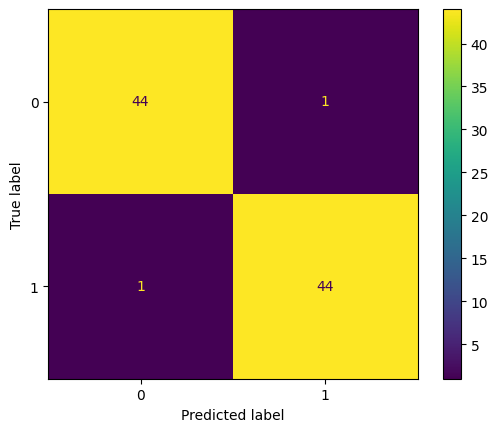

Accuracy: 0.9777777777777777
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.98      0.98      0.98        45

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [10]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Inicializar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

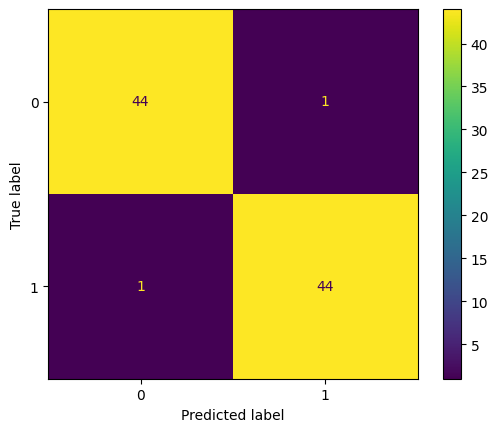

Accuracy: 0.9777777777777777
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.98      0.98      0.98        45

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [11]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Selecionar as top features
num_top_features = 30
top_features = X_train.columns[indices[:num_top_features]]


# Plotar as top features
plt.figure(figsize=(10, 8))
plt.title("Top 30 Features Importances")
plt.barh(range(num_top_features), importances[indices[:num_top_features]], align='center')
plt.yticks(range(num_top_features), top_features)
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Gradient Boosting Classifier

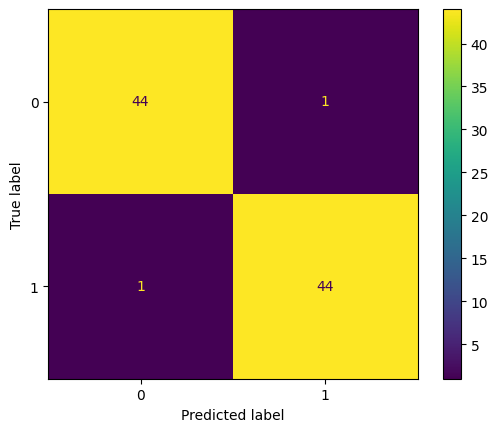

Accuracy: 0.9777777777777777
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.98      0.98      0.98        45

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [12]:
# Gradient Boosting 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Inicializar o modelo Random Forest
rf_model = GradientBoostingClassifier(random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')



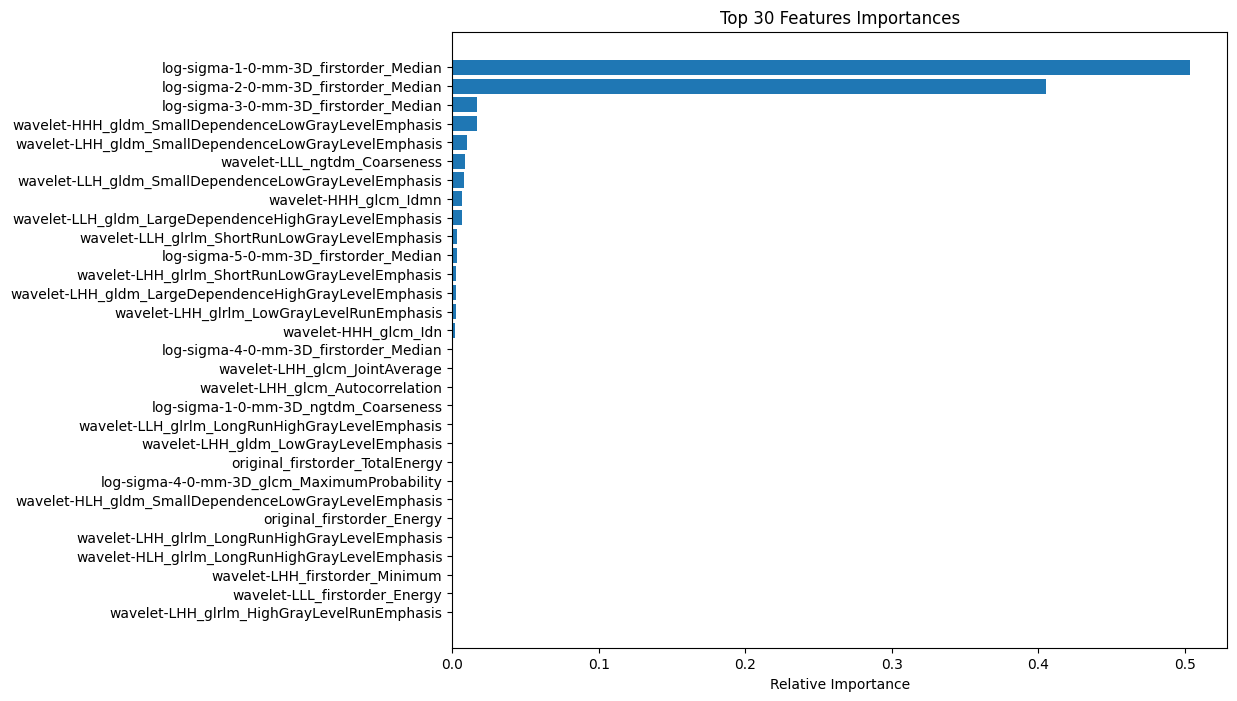

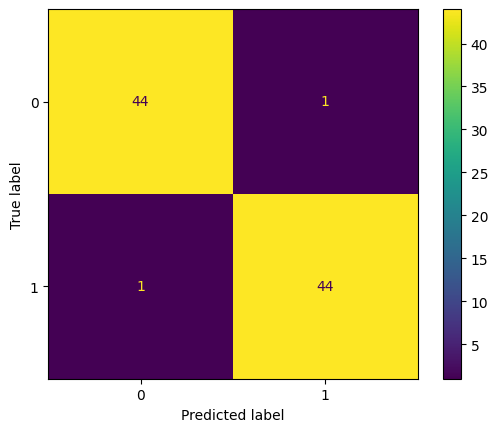

Accuracy: 0.9777777777777777
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.98      0.98      0.98        45

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [13]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Selecionar as top features
num_top_features = 30
top_features = X_train.columns[indices[:num_top_features]]


# Plotar as top features
plt.figure(figsize=(10, 8))
plt.title("Top 30 Features Importances")
plt.barh(range(num_top_features), importances[indices[:num_top_features]], align='center')
plt.yticks(range(num_top_features), top_features)
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Logistic Regression

In [15]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logistic_model = LogisticRegression()

# Treinar o modelo
logistic_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = logistic_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


Accuracy: 0.9888888888888889
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.98      0.99        45

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



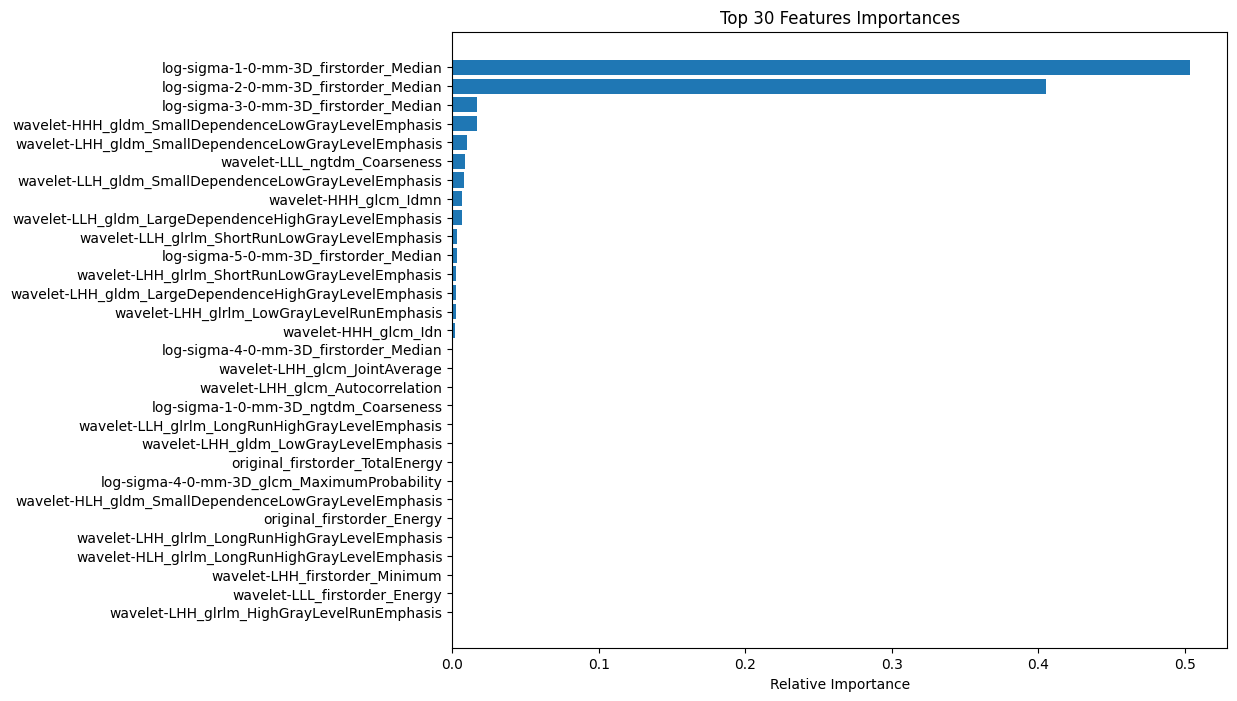

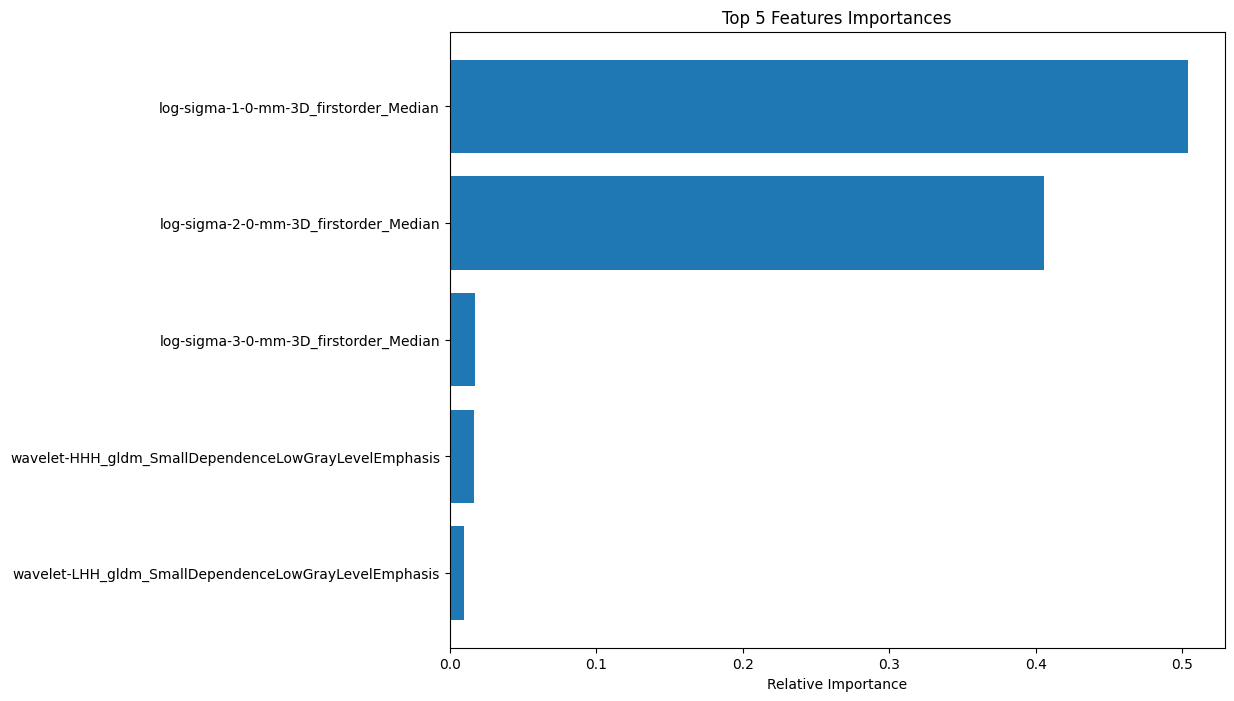

Accuracy: 0.9888888888888889
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.98      0.99        45

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



In [16]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Selecionar as top features
num_top_features = 30
num_top_features1 = 5
top_features = X_train.columns[indices[:num_top_features]]
top1 = X_train.columns[indices[:num_top_features1]]


# Plotar as top features
plt.figure(figsize=(10, 8))
plt.title("Top 30 Features Importances")
plt.barh(range(num_top_features), importances[indices[:num_top_features]], align='center')
plt.yticks(range(num_top_features), top_features)
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

plt.figure(figsize=(10, 8))
plt.title("Top 5 Features Importances")
plt.barh(range(num_top_features1), importances[indices[:num_top_features1]], align='center')
plt.yticks(range(num_top_features1), top1)
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Decision Tree Classifier

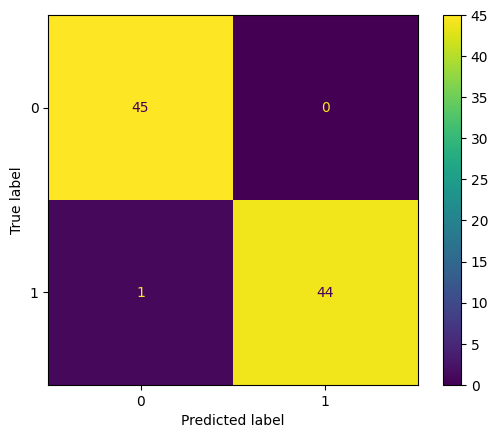

Accuracy: 0.9888888888888889
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.98      0.99        45

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



In [17]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logistic_model = DecisionTreeClassifier()

# Treinar o modelo
logistic_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = logistic_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


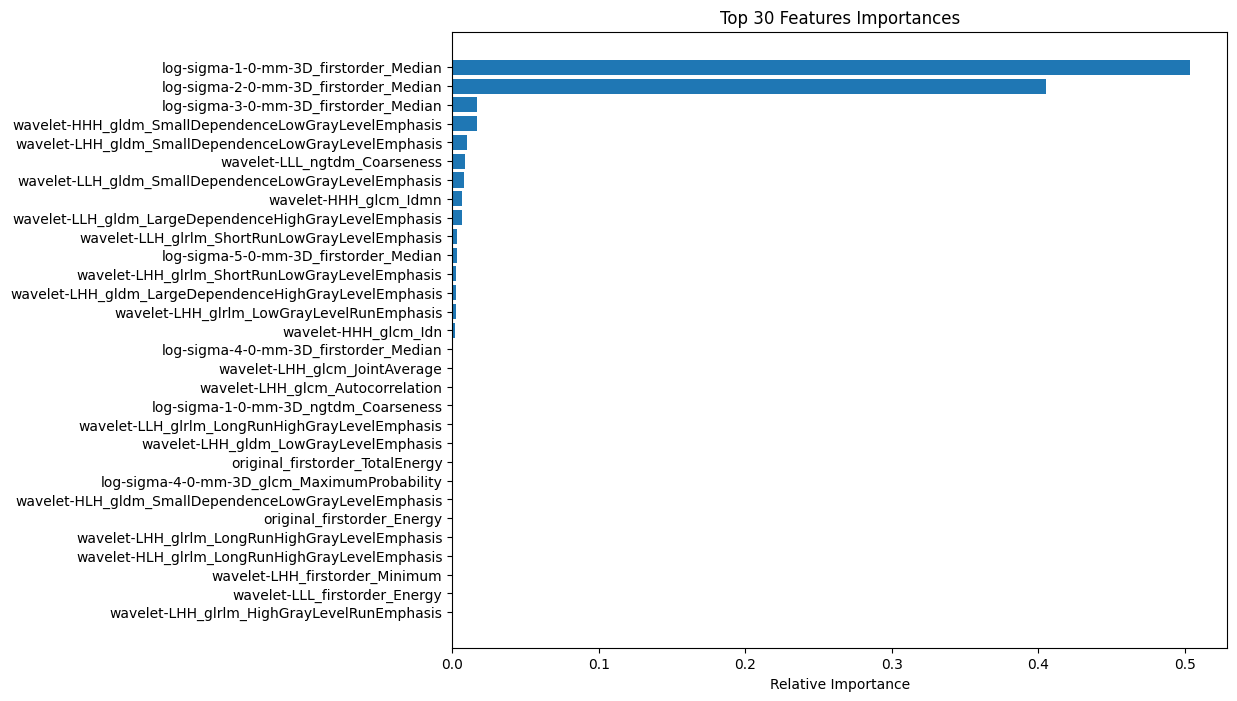

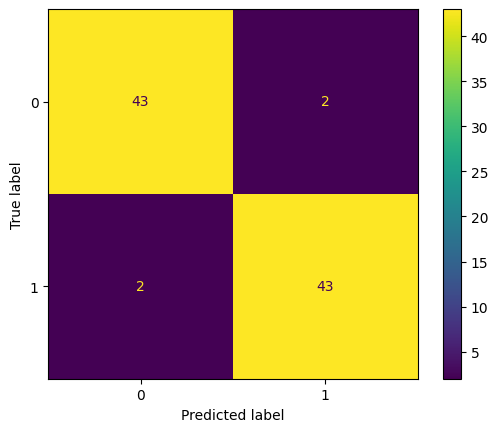

Accuracy: 0.9555555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       0.96      0.96      0.96        45

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



In [18]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Selecionar as top features
num_top_features = 30
top_features = X_train.columns[indices[:num_top_features]]


# Plotar as top features
plt.figure(figsize=(10, 8))
plt.title("Top 30 Features Importances")
plt.barh(range(num_top_features), importances[indices[:num_top_features]], align='center')
plt.yticks(range(num_top_features), top_features)
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')